In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/DeepLearning/ComputerVision/yolo_transfer
!ls
# link: https://kikaben.com/yolov5-transfer-learning-dogs-cats/

Mounted at /content/drive
/content/drive/MyDrive/DeepLearning/ComputerVision/yolo_transfer
cats_and_dogs.yaml  prepare_data.ipynb	transfer.ipynb


## Dowload data

In [2]:
!pip install -q openimages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
!oi_download_dataset --base_dir download --csv_dir download --labels Cat Dog --format darknet

In [5]:
from openimages.download import download_dataset
download_dataset("download", ["Cat", "Dog",], annotation_format="darknet", limit=2000)


# => số lượng mẫu mèo 2000.
# => số lượng mẫu chó 2000.

100%|██████████| 2000/2000 [00:17<00:00, 111.85it/s]


{'cat': {'images_dir': 'download/cat/images',
  'annotations_dir': 'download/cat/darknet'},
 'dog': {'images_dir': 'download/dog/images',
  'annotations_dir': 'download/dog/darknet'}}

## Show image

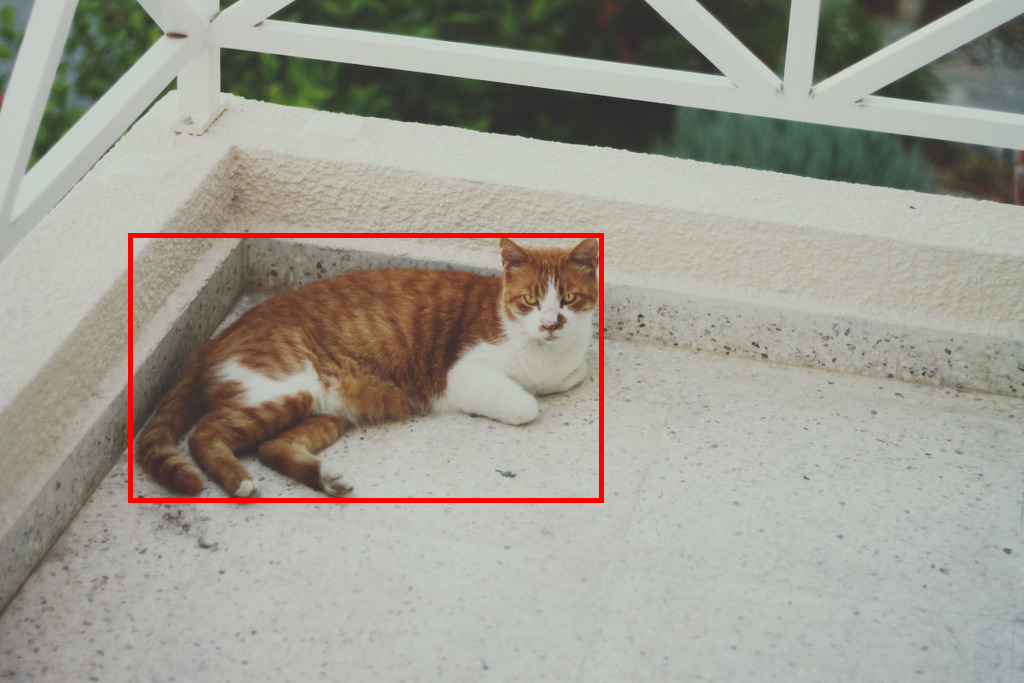

In [6]:
from PIL import Image, ImageDraw

def show_bbox(image_path):
    # đổi đường dẫn image sang đường dẫn nhãn
    label_path = image_path.replace('/images/', '/darknet/')
    label_path = label_path.replace('.jpg', '.txt')

    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    with open(label_path, 'r') as f:
        for line in f.readlines():
            # Load các nhãn.
            label, x, y, w, h = line.split(' ')

            # Chuyển đổi string sang float
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)

            # Chuyển đổi center position, width, height sang
            # top-left và bottom-right
            W, H = image.size
            x1 = (x - w/2) * W
            y1 = (y - h/2) * H
            x2 = (x + w/2) * W
            y2 = (y + h/2) * H

            # Vẽ bounding box
            draw.rectangle((x1, y1, x2, y2),
                           outline=(255, 0, 0),
                           width=5)
    image.show()


# import glob
# dogs = glob.glob("download/dog/images/*.jpg")[0]
# show_bbox(dogs)
show_bbox('download/cat/images/0a0df46ca3f886c9.jpg')

## Setup folder for training

data
  + images
    + test
    + train
    + val
  + labels
    + test
    + train
    + val

In [7]:
import os

# Khởi tạo folder data
if not os.path.exists('data'):
    for folder in ['images', 'labels']:
        for split in ['train', 'val', 'test']:
            os.makedirs(f'data/{folder}/{split}')

In [8]:
import glob
import os

def get_filenames(folder):
    filenames = set()

    for path in glob.glob(os.path.join(folder, '*.jpg')):

        filename = os.path.split(path)[-1]
        filenames.add(filename)

    return filenames


# paths của '
dog_images = get_filenames('download/dog/images')
cat_images = get_filenames('download/cat/images')

print("Số lượng mẫu nhãn mèo:", len(cat_images))
print("Số lượng mẫu nhãn chó:", len(dog_images))

Số lượng mẫu nhãn mèo: 2000
Số lượng mẫu nhãn chó: 2000


#### Kiểm tra xem có các file bị trùng hay không (nếu có loại bỏ)

In [9]:
# Kiểm tra các số lượng file bị trùng ở 2 lớp chó và mèo
duplicates = dog_images & cat_images

print(f"Số lượng file bị trùng của 2 lớp: {len(duplicates)}")

Số lượng file bị trùng của 2 lớp: 15


In [10]:
# bỏ những file bị trùng
dog_images -= duplicates
cat_images -= duplicates

print("Số lượng mẫu mèo sau khi bỏ các mẫu bị trùng", len(cat_images))
print("Số lượng mẫu chó sau khi bỏ các mẫu bị trùng", len(dog_images))

Số lượng mẫu mèo sau khi bỏ các mẫu bị trùng 1985
Số lượng mẫu chó sau khi bỏ các mẫu bị trùng 1985


#### Setup các folder chuẩn bị cho quá trình huấn luyện

In [11]:
import numpy as np

dog_images = np.array(list(dog_images))
cat_images = np.array(list(cat_images))

# trỗn random các mẫu
np.random.seed(42)
np.random.shuffle(dog_images)
np.random.shuffle(cat_images)

In [12]:
import shutil
from tqdm import tqdm


def split_dataset(animal, image_names, train_size, val_size):
    for i, image_name in tqdm(enumerate(image_names)):
        # Label filename
        label_name = image_name.replace('.jpg', '.txt')

        # Split into train, val, or test
        if i < train_size:
            split = 'train'
        elif i < train_size + val_size:
            split = 'val'
        else:
            split = 'test'

        # Source paths
        source_image_path = f'download/{animal}/images/{image_name}'
        source_label_path = f'download/{animal}/darknet/{label_name}'

        # Destination paths
        target_image_folder = f'data/images/{split}'
        target_label_folder = f'data/labels/{split}'

        # Copy files
        shutil.copy(source_image_path, target_image_folder)
        shutil.copy(source_label_path, target_label_folder)


num_dogs = len(dog_images)
num_cats = len(cat_images)

# Cat data
split_dataset('cat', cat_images, train_size=int(num_cats*0.8), val_size=int(num_cats*0.1))

# Dog data
split_dataset('dog', dog_images, train_size=int(num_dogs*0.8), val_size=int(num_dogs*0.1))

print()
print(f"Số lượng các mẫu lớp mèo: {int(num_cats*0.8)} - {int(num_cats*0.1)} - {num_cats - int(num_cats*0.8) - int(num_dogs*0.1)}" )
print(f"Số lượng các mẫu lớp chó: {int(num_dogs*0.8)} - {int(num_dogs*0.1)} - {num_dogs - int(num_dogs*0.8) - int(num_dogs*0.1)}" )

1985it [00:46, 42.81it/s]
1985it [00:52, 37.63it/s]


Số lượng các mẫu lớp mèo: 1588 - 198 - 199
Số lượng các mẫu lớp chó: 1588 - 198 - 199


In [13]:
print("Số lượng mẫu trong tập huấn luyện (train):", len(os.listdir("data/images/train")))
print("Số lượng mẫu trong tập kiểm định (validation):",len(os.listdir("data/images/val")))
print("Số lượng mẫu trong tập kiểm thử (test):", len(os.listdir("data/images/test")))

Số lượng mẫu trong tập huấn luyện (train): 3176
Số lượng mẫu trong tập kiểm định (validation): 396
Số lượng mẫu trong tập kiểm thử (test): 398


In [14]:
print("Số lượng mẫu trong tập huấn luyện (train):", len(os.listdir("data/labels/train")))
print("Số lượng mẫu trong tập kiểm định (validation):",len(os.listdir("data/labels/val")))
print("Số lượng mẫu trong tập kiểm thử (test):", len(os.listdir("data/labels/test")))

Số lượng mẫu trong tập huấn luyện (train): 3176
Số lượng mẫu trong tập kiểm định (validation): 396
Số lượng mẫu trong tập kiểm thử (test): 398
